In [2]:
import sys
sys.path.insert(0, sys.path[0]+"/../")

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from tfnet.evaluation import get_mean_auc, get_auc, get_mean_f1, get_mean_balanced_accuracy_score, get_mean_recall, get_mean_aupr, get_aupr, get_mean_precision
import gzip
import subprocess

from typing import *
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import colorsys
import warnings
import scipy
from statannot import add_stat_annotation
from statannotations.Annotator import Annotator

In [7]:
def read_predict(predict_file):
    with gzip.open(predict_file, 'rt') as fp:
        targets_list = []
        ori_predict_list = []
        predict_list = []
        for line in fp:
            chr, start, stop, targets, ori_predict, predict = line.split('\t')
            targets_list.append(ast.literal_eval(targets))
            ori_predict_list.append(ast.literal_eval(ori_predict))
            predict_list.append(ast.literal_eval(predict))
    targets_array = np.array(targets_list)
    ori_predict_array = np.array(ori_predict_list)
    predict_array = np.array(predict_list)
    return targets_array,ori_predict_array,predict_array

In [12]:
A549 =  ["ATOH8","BCL3","BHLHE40","CBX2","CEBPB","CTCF","E2F6","EHF","ELK1","EP300","ESRRA","FOSL2","FOXF2","FOXS1","GATA3","HES2","HEYL","HMGA2","HMGXB4","HOXA7","HOXB13","HOXB5","JUN","MAFK","MAX","MAZ","MYC","NFE2L2","NR2E3","NR3C1","NR5A2","PBX1","PBX3","PRDM1","RARB","RCOR1","REST","RFX5","RNF2","SREBF1","SREBF2","TEAD4","TP53","TP63","USF2","ZNF302","ZNF624","ZSCAN20"]

GM12878 = ["ARID3A", "ARNT", "ATF2", "ATF3", "BACH1", "BATF", "BCL11A", "BCL3", "BCLAF1", "BHLHE40", "BMI1", "CBFB", "CEBPB", "CEBPZ", "CREB1", "CREM", "CTCF", "CUX1", "E2F4", "E2F8", "E4F1", "EBF1", "EGR1", "ELF1", "ELK1", "EP300", "ESRRA", "ETS1", "ETV6", "FOS", "FOXK2", "GABPA", "GATAD2B", "HSF1", "IKZF1", "IKZF2", "IRF3", "IRF4", "IRF5", "JUND", "KLF5", "MAFK", "MAX", "MAZ", "MEF2A", "MEF2B", "MEF2C", "MLLT1", "MXI1", "MYC", "NFATC1", "NFATC3", "NFIC", "NFXL1", "NFYA", "NFYB", "NKRF", "NR2C1", "NR2C2", "NR2F1", "NRF1", "PAX5", "PAX8", "PBX3", "PKNOX1", "POU2F2", "PRDM15", "RCOR1", "RELA", "RELB", "REST", "RFX5", "RUNX3", "RXRA", "SIX5", "SKIL", "SMAD1", "SMAD5", "SREBF1", "SREBF2", "SRF", "STAT1", "STAT3", "STAT5A", "TBP", "TBX21", "TCF12", "TCF3", "TCF7", "TRIM22", "UBTF", "USF1", "USF2", "YBX1", "YY1", "ZBED1", "ZBTB11", "ZBTB33", "ZBTB4", "ZBTB40", "ZEB1", "ZNF143", "ZNF217", "ZNF24", "ZNF384", "ZNF592", "ZNF687", "ZSCAN29", "ZZZ3"]

H1 = ["ATF2","ATF3","BACH1","CEBPB","CHD7","CREB1","CTCF","E2F6","EGR1","EP300","FOSL1","GABPA","JUN","JUND","MAFK","MAX","MXI1","MYC","NANOG","NRF1","POU5F1","REST","RFX5","RNF2","RXRA","SIX5","SP1","SP2","SP4","SRF","TBP","TCF12","TEAD4","USF1","USF2","YY1","ZNF143","ZNF274"]

HEK293 = ["AEBP2","ATF2","BCL11A","BCL11B","BCL6B","CBLL2","CTCF","EGR2","ELK4","FEZF1","GFI1B","GLI2","GLI4","GLIS1","GLIS2","HIC1","HOXA7","HOXB7","HOXC10","HOXD13","IKZF3","INSM2","KLF1","KLF10","KLF16","KLF17","KLF7","KLF8","KLF9","MAZ","MEIS1","MYNN","MZF1","OSR2","OVOL3","PATZ1","PBX3","PRDM1","PRDM10","PRDM2","PRDM4","PRDM6","RBAK","REST","SALL2","SCRT1","SCRT2","SP2","SP3","SP7","TCF7L2","TRIM28","TSHZ1","WT1","YY1","YY2","ZBTB10","ZBTB11","ZBTB12","ZBTB17","ZBTB20","ZBTB21","ZBTB26","ZBTB44","ZBTB48","ZBTB49","ZBTB6","ZBTB8A","ZEB1","ZEB2","ZFHX2","ZFP3","ZFP37","ZFP41","ZFP69B","ZIC2","ZNF10","ZNF112","ZNF114","ZNF121","ZNF132","ZNF133","ZNF138","ZNF140","ZNF146","ZNF148","ZNF155","ZNF157","ZNF16","ZNF169","ZNF174","ZNF175","ZNF18","ZNF184","ZNF189","ZNF19","ZNF2","ZNF202","ZNF211","ZNF214","ZNF221","ZNF223","ZNF23","ZNF239","ZNF24","ZNF248","ZNF26","ZNF263","ZNF266","ZNF274","ZNF280C","ZNF280D","ZNF292","ZNF302","ZNF311","ZNF324","ZNF34","ZNF341","ZNF350","ZNF354C","ZNF362","ZNF37A","ZNF391","ZNF394","ZNF398","ZNF404","ZNF416","ZNF423","ZNF426","ZNF433","ZNF449","ZNF473","ZNF48","ZNF488","ZNF501","ZNF510","ZNF513","ZNF514","ZNF518A","ZNF521","ZNF529","ZNF530","ZNF544","ZNF547","ZNF548","ZNF549","ZNF555","ZNF558","ZNF560","ZNF561","ZNF571","ZNF580","ZNF585B","ZNF596","ZNF600","ZNF610","ZNF621","ZNF623","ZNF624","ZNF626","ZNF629","ZNF639","ZNF654","ZNF658","ZNF660","ZNF664","ZNF670","ZNF677","ZNF680","ZNF692","ZNF701","ZNF704","ZNF707","ZNF747","ZNF76","ZNF770","ZNF776","ZNF777","ZNF785","ZNF791","ZNF792","ZNF837","ZNF843","ZSCAN16","ZSCAN18","ZSCAN21","ZSCAN23","ZSCAN26","ZSCAN30","ZSCAN4","ZSCAN5A","ZSCAN5C","ZXDB"]

HeLaS3 = ["BRF2","CEBPB","CTCF","E2F1","E2F4","E2F6","ELK1","ELK4","EP300","FOS","GABPA","GTF3C2","IRF3","JUN","JUND","MAFF","MAFK","MAX","MAZ","MXI1","MYC","NFE2L2","NFYA","NFYB","NR2C2","NRF1","PRDM1","RCOR1","REST","RFX5","SREBF2","STAT3","TBP","TCF7L2","UBTF","USF2","ZHX1","ZKSCAN1","ZNF143","ZNF274","ZZZ3"]

HepG2 = ["MTERF2","ADNP","AFF4","AHDC1","AHR","AKNA","ARHGAP35","ARID3A","ARID4A","ARID4B","ARID5B","ARNT","ARNT2","ARNTL","ATAD3A","ATF1","ATF2","ATF3","ATF4","ATF5","ATF6","BATF2","BAZ2A","BCL3","BCL6","BHLHA15","BHLHE40","BRF2","CBFB","CBX2","CC2D1A","CEBPA","CEBPB","CEBPD","CEBPG","CEBPZ","CENPBD1","CERS6","CHCHD3","CREB1","CREB3","CREBL2","CREM","CSRNP1","CSRNP2","CTCF","DBP","DDIT3","DLX6","DMTF1","DRAP1","DZIP1","E2F1","E2F2","E2F4","E2F5","E2F8","EEA1","EGR1","ELF1","ELF4","ELK1","ELK4","EP300","ESRRA","ETS1","ETV4","ETV5","ETV6","FBXL19","FOSL1","FOSL2","FOXA1","FOXA2","FOXA3","FOXC1","FOXJ3","FOXK1","FOXK2","FOXO1","FOXO4","FOXP4","FOXQ1","FUBP1","FUBP3","GABPA","GABPB1","GATA2","GATA4","GATAD2B","GFI1","GLI4","GLMP","GLYR1","GMEB1","GMEB2","GPBP1L1","GPN1","GRHL1","GZF1","HBP1","HHEX","HIC2","HINFP","HIVEP1","HLF","HMG20A","HMG20B","HMGXB3","HMGXB4","HNF1A","HNF1B","HNF4A","HNF4G","HNRNPK","HOMEZ","HOXA10","HOXA3","HOXA5","HOXA7","HOXA9","HOXD1","HSF2","IKZF1","IKZF4","IKZF5","IRF1","IRF2","IRF3","IRF5","IRF9","IRX3","ISL2","ISX","JUN","JUND","KDM6A","KLF11","KLF12","KLF13","KLF15","KLF16","KLF6","KLF9","LBX2","LCOR","LCORL","LIN54","LRRFIP1","MAF1","MAFF","MAFG","MAFK","MAX","MAZ","MBD1","MEF2A","MEF2D","MEIS1","MEIS2","MGA","MIXL1","MLLT10","MLX","MLXIP","MNT","MNX1","MTERF4","MTF1","MXD1","MXD3","MXI1","MYBL2","MYC","MYNN","MYPOP","MYRF","MZF1","NACC2","NFAT5","NFATC3","NFE2","NFE2L2","NFIA","NFIB","NFIC","NFIL3","NFKB2","NFYA","NFYB","NFYC","NKX3-1","NR0B2","NR1H2","NR2C2","NR2F1","NR2F2","NR2F6","NR3C1","NR5A1","NRF1","NRL","ONECUT1","ONECUT2","PATZ1","PAX8","PAXIP1","PBX2","PBX3","PHB2","PITX1","PLSCR1","POGK","POU2F1","PPARG","PRDM10","PRDM15","PRDM4","PREB","PROX1","RARG","RBAK","RBPJ","RBSN","RCOR1","RCOR2","REL","RELA","RERE","REST","RFX1","RFX3","RFX5","RNF2","RNF219","RORA","RREB1","RXRA","RXRB","SALL1","SALL2","SATB2","SFPQ","SIX1","SIX4","SKIL","SMAD1","SMAD3","SMAD4","SMAD7","SMAD9","SNAI1","SNAPC4","SNAPC5","SOX13","SOX18","SOX5","SOX6","SP1","SP110","SP140L","SP2","SP4","SP5","SRF","SRY","STAT5B","STAT6","TBP","TBX2","TBX3","TCF12","TCF3","TCF7","TCF7L2","TEAD1","TEAD2","TEAD4","TEF","TERF1","TFAP4","TFDP1","TFDP2","TFE3","TGIF2","THAP11","THAP4","THAP7","THAP8","THAP9","THRA","THRB","TIGD3","TIGD6","TOPORS","TP53","TRAFD1","TRIM22","TRIM24","TSC22D1","TSC22D2","UBTF","USF1","USF2","USF3","XBP1","XRCC5","YBX1","YY1","ZBED4","ZBED5","ZBTB10","ZBTB14","ZBTB2","ZBTB20","ZBTB21","ZBTB24","ZBTB25","ZBTB26","ZBTB3","ZBTB33","ZBTB34","ZBTB37","ZBTB39","ZBTB4","ZBTB40","ZBTB42","ZBTB43","ZBTB44","ZBTB46","ZBTB49","ZBTB7B","ZBTB8A","ZC3H8","ZEB1","ZFAT","ZFHX3","ZFP1","ZFP14","ZFP37","ZFP41","ZFP62","ZFP64","ZFP82","ZFP90","ZFP91","ZFY","ZGPAT","ZHX1","ZHX2","ZHX3","ZIK1","ZKSCAN1","ZKSCAN5","ZKSCAN8","ZMAT5","ZMYM2","ZMYM3","ZMYM4","ZNF10","ZNF101","ZNF12","ZNF121","ZNF124","ZNF138","ZNF142","ZNF143","ZNF146","ZNF160","ZNF17","ZNF18","ZNF180","ZNF181","ZNF20","ZNF205","ZNF217","ZNF219","ZNF221","ZNF224","ZNF225","ZNF230","ZNF232","ZNF234","ZNF235","ZNF24","ZNF25","ZNF251","ZNF253","ZNF256","ZNF260","ZNF263","ZNF264","ZNF274","ZNF275","ZNF276","ZNF280B","ZNF280D","ZNF281","ZNF282","ZNF292","ZNF296","ZNF3","ZNF30","ZNF317","ZNF318","ZNF329","ZNF331","ZNF333","ZNF337","ZNF33A","ZNF33B","ZNF34","ZNF343","ZNF350","ZNF354B","ZNF362","ZNF367","ZNF382","ZNF383","ZNF384","ZNF407","ZNF414","ZNF430","ZNF431","ZNF432","ZNF44","ZNF441","ZNF446","ZNF460","ZNF468","ZNF48","ZNF483","ZNF484","ZNF485","ZNF490","ZNF496","ZNF501","ZNF503","ZNF510","ZNF511","ZNF512","ZNF512B","ZNF513","ZNF526","ZNF527","ZNF530","ZNF543","ZNF546","ZNF547","ZNF548","ZNF549","ZNF550","ZNF552","ZNF556","ZNF557","ZNF558","ZNF562","ZNF563","ZNF564","ZNF567","ZNF569","ZNF570","ZNF571","ZNF572","ZNF574","ZNF576","ZNF577","ZNF580","ZNF589","ZNF597","ZNF605","ZNF607","ZNF608","ZNF609","ZNF614","ZNF615","ZNF616","ZNF619","ZNF629","ZNF639","ZNF644","ZNF646","ZNF652","ZNF660","ZNF670","ZNF672","ZNF674","ZNF678","ZNF687","ZNF691","ZNF697","ZNF7","ZNF704","ZNF707","ZNF709","ZNF710","ZNF713","ZNF720","ZNF724","ZNF737","ZNF740","ZNF746","ZNF747","ZNF749","ZNF75D","ZNF761","ZNF766","ZNF770","ZNF772","ZNF773","ZNF775","ZNF776","ZNF777","ZNF778","ZNF780A","ZNF781","ZNF782","ZNF784","ZNF786","ZNF788P","ZNF790","ZNF792","ZNF800","ZNF816","ZNF827","ZNF83","ZNF839","ZNF841","ZNF850","ZNF865","ZNF878","ZNF879","ZNF883","ZNF891","ZSCAN12","ZSCAN20","ZSCAN21","ZSCAN22","ZSCAN25","ZSCAN29","ZSCAN30","ZSCAN31","ZSCAN5A","ZSCAN9","ZUP1","ZXDC","ZZZ3"]

K562 = ["ADNP","AFF1","AFF4","ARHGAP35","ARID1B","ARID3A","ARID3B","ARID4B","ARNT","ATF1","ATF2","ATF3","ATF4","ATF6","BACH1","BCL6","BCLAF1","BHLHE40","BMI1","CBFB","CBX1","CC2D1A","CDC5L","CEBPB","CEBPG","CEBPZ","CGGBP1","CHAMP1","CHCHD3","CLOCK","CREB1","CREB3","CREB3L1","CREB5","CREM","CTCF","CTCFL","CUX1","DACH1","DDIT3","DEAF1","DLX4","DMBX1","DMTF1","E2F1","E2F3","E2F4","E2F5","E2F6","E2F7","E2F8","E4F1","EGR1","ELF1","ELF2","ELF4","ELK1","ELK3","EP300","ESRRA","ESRRB","ETS1","ETS2","ETV1","ETV5","ETV6","FOS","FOSL1","FOXA1","FOXA3","FOXJ2","FOXJ3","FOXK1","FOXK2","FOXO4","FOXP4","GABPA","GABPB1","GABPB2","GATA1","GATA2","GATAD2B","GMEB1","GTF2B","GTF2I","GTF3C2","HBP1","HES1","HEY1","HINFP","HIVEP1","HMBOX1","HMG20A","HMG20B","HMGXB4","HNRNPK","HOMEZ","ID3","IFI16","IKZF1","ILK","IRF1","IRF2","IRF9","JUN","JUND","KLF1","KLF10","KLF13","KLF16","KLF6","LCOR","LEF1","MAFF","MAFG","MAFK","MAX","MAZ","MBD1","MECOM","MEF2A","MEF2D","MEIS2","MGA","MITF","MLLT1","MLX","MNT","MTF1","MXD1","MXI1","MYBL2","MYC","MYNN","NEUROD1","NFATC3","NFE2","NFIC","NFIX","NFXL1","NFYA","NFYB","NKRF","NR0B1","NR1H2","NR2C1","NR2C2","NR2F1","NR2F2","NR2F6","NR3C1","NR4A1","NRF1","OTX1","PATZ1","PBX2","PHB2","PHTF2","PKNOX1","POU5F1","PPARD","PRDM10","PREB","PTTG1","RBPJ","RCOR1","RELA","RERE","REST","RFX1","RFX5","RFX7","RHOXF2B","RLF","RNF2","RNF219","RREB1","RUNX1","SFPQ","SIX5","SKIL","SMAD1","SMAD2","SMAD3","SMAD4","SMAD5","SNAPC5","SOX6","SP1","SP2","SREBF1","SREBF2","SRF","STAT5A","STAT5B","STAT6","TBPL1","TBX18","TCF12","TCF15","TCF3","TCF7","TCF7L2","TCFL5","TEAD1","TEAD2","TEAD4","TFAP4","TFCP2","TFDP1","TFE3","TGIF2","THAP1","THAP12","THAP7","THRA","THRB","TRIM24","TRIM25","TRIM28","TSC22D4","TSHZ1","UBTF","USF1","USF2","VEZF1","XRCC5","YBX1","YY1","ZBED1","ZBTB11","ZBTB12","ZBTB17","ZBTB2","ZBTB26","ZBTB33","ZBTB34","ZBTB40","ZBTB43","ZBTB49","ZBTB5","ZBTB8A","ZBTB9","ZC3H8","ZEB2","ZFP1","ZFP30","ZFP91","ZHX1","ZKSCAN1","ZKSCAN3","ZKSCAN8","ZMIZ1","ZMYM3","ZNF12","ZNF121","ZNF124","ZNF133","ZNF134","ZNF140","ZNF143","ZNF148","ZNF165","ZNF174","ZNF175","ZNF184","ZNF197","ZNF212","ZNF215","ZNF217","ZNF224","ZNF23","ZNF232","ZNF239","ZNF24","ZNF253","ZNF257","ZNF263","ZNF274","ZNF277","ZNF280A","ZNF280B","ZNF281","ZNF282","ZNF3","ZNF311","ZNF316","ZNF317","ZNF318","ZNF319","ZNF324","ZNF347","ZNF354B","ZNF354C","ZNF384","ZNF395","ZNF397","ZNF398","ZNF407","ZNF408","ZNF41","ZNF431","ZNF436","ZNF444","ZNF445","ZNF449","ZNF507","ZNF511","ZNF512","ZNF518B","ZNF551","ZNF561","ZNF57","ZNF583","ZNF584","ZNF586","ZNF589","ZNF592","ZNF609","ZNF639","ZNF644","ZNF655","ZNF668","ZNF695","ZNF696","ZNF699","ZNF7","ZNF700","ZNF707","ZNF717","ZNF740","ZNF75A","ZNF76","ZNF764","ZNF766","ZNF77","ZNF778","ZNF780A","ZNF785","ZNF79","ZNF83","ZNF84","ZSCAN29","ZSCAN32","ZZZ3"]
  
MCF7 = ["ARID3A","BMI1","CEBPB","CEBPG","CLOCK","CREB1","CTCF","CUX1","E2F1","E2F4","E2F8","E4F1","EGR1","ELF1","ELK1","EP300","ESR1","ESRRA","FOS","FOSL2","FOXA1","FOXK2","GABPA","GATA3","GATAD2B","HES1","HSF1","JUN","JUND","KLF4","KLF9","MAFK","MAX","MAZ","MLLT1","MNT","MSX2","MYC","NEUROD1","NFIB","NFXL1","NR2F2","NRF1","OTX1","OVOL1","PAX8","PKNOX1","RCOR1","REST","RFX1","RFX5","SIX4","SP1","SPDEF","SREBF1","SRF","TCF12","TCF7L2","TEAD4","TRIM22","TSC22D1","TSC22D2","YBX1","ZBTB11","ZBTB33","ZBTB40","ZBTB7B","ZHX2","ZKSCAN1","ZNF217","ZNF227","ZNF24","ZNF331","ZNF444","ZNF507","ZNF512B","ZNF574","ZNF592","ZNF687","ZNF8"]
  
SKNSH = ["ARNTL","BACH2","BNC2","CREB5","CSRNP3","CTCF","ELF1","EP300","ESRRG","FOSL2","FOXJ3","GABPA","GATA2","GATA3","GLIS3","IRF3","ISL1","JUND","MAX","MEF2A","MXI1","NFIC","NRF1","OSR1","PATZ1","PBX3","POU6F1","PPARA","RARB","RCOR1","REST","RFX5","RXRA","SNAI2","TCF12","TCF4","TEAD4","TFAP2B","TOX","TOX2","TSHZ2","USF1","USF2","YY1","ZBTB33","ZFP3","ZFP30","ZNF565","ZNF608","ZNF70","ZNF8"]
  
WTC11 = ["AFF4","AR","ARID4B","ATF1","ATF2","ATF3","ATF6","CBFB","CDX4","CREB1","CREM","CTCF","E2F1","E2F4","E2F5","ELF4","EMX1","ERG","ESRRA","ETV6","FOXJ3","FOXK1","FOXP4","GABPB1","GRHL2","GTF2I","HMGA2","HMGXB4","IRF1","IRF2","JUN","MAX","MLX","MYBL2","NFATC4","NFYB","NR1H2","NR2C2","NR3C1","OTX2","OVOL2","PRDM15","PREB","PRRX2","RELA","RORB","SIX4","SMAD3","SMAD4","SOX15","SP1","STAT6","TCF7","TEAD1","TEAD4","TGIF2","TP53","TRERF1","USF1","USF2","ZBTB21","ZBTB33","ZBTB43","ZKSCAN8","ZMAT4","ZNF121","ZNF138","ZNF143","ZNF184","ZNF219","ZNF232","ZNF263","ZNF281","ZNF317","ZNF396","ZNF416","ZNF423","ZNF425","ZNF512","ZNF532","ZNF671","ZSCAN18"]

#### load data

In [13]:
target_tfs_1 = "BATF"
index1 = GM12878.index(target_tfs_1)
target_tfs_2 = "TFAP4"
index2 = HepG2.index(target_tfs_2)

In [ ]:
# awk -v OF='\t' -v OFS='\t' '{split($4, arr1, ","); split($5, arr2, ","); split($6, arr3, ","); print $1, $2, arr1[6], arr2[6], arr3[6];}' file_name > select.data_all.txt.eval.tsv

In [9]:
subprocess.run("ls")

bed2bw.liftOver.sh
eval.plot.ipynb
label_transfer.py
peak2bed.sh
scATAC.R


CompletedProcess(args='ls', returncode=0)

In [25]:
eval_result_1 = pd.read_csv("../results/valid/w200s200/select.TFNet3_GM12878.BATF-TFAP4-knockin.BATF.generate.GM12878.data_all.txt.eval.tsv", header=None, index_col=None, sep='\t')
eval_result_1['group'] = "BATF-TFAP4-knockin-BATF"
eval_result_2 = pd.read_csv("../results/valid/w200s200/select.TFNet3_GM12878.TFAP4-knockin.BATF.generate.GM12878.data_all.txt.eval.tsv", header=None, index_col=None, sep='\t')
eval_result_2['group'] = "TFAP4-knockin-BATF"
eval_result_3 = pd.read_csv("../results/valid/w200s200/select.TFNet3_GM12878.tNGFR-knockin.BATF.generate.GM12878.data_all.txt.eval.tsv", header=None, index_col=None, sep='\t')
eval_result_3['group'] = "tNGFR-knockin-BATF"

eval_result_4 = pd.read_csv("../results/valid/w200s200/select.TFNet3_HepG2.BATF-TFAP4-knockin.TFAP4.generate.HepG2.data_all.txt.eval.tsv", header=None, index_col=None, sep='\t')
eval_result_4['group'] = "BATF-TFAP4-knockin-TFAP4"
eval_result_5 = pd.read_csv("../results/valid/w200s200/select.TFNet3_HepG2.TFAP4-knockin.TFAP4.generate.HepG2.data_all.txt.eval.tsv", header=None, index_col=None, sep='\t')
eval_result_5['group'] = "TFAP4-knockin-TFAP4"
eval_result_6 = pd.read_csv("../results/valid/w200s200/select.TFNet3_HepG2.tNGFR-knockin.TFAP4.generate.HepG2.data_all.txt.eval.tsv", header=None, index_col=None, sep='\t')
eval_result_6['group'] = "tNGFR-knockin-TFAP4"

empty_eval_result_1 = pd.read_csv("../results/valid/w200s200/empty.select.TFNet3_GM12878.BATF-TFAP4-knockin.BATF.generate.GM12878.data_all.txt.eval.tsv", header=None, index_col=None, sep='\t')
empty_eval_result_1["group"] = "Empty-BATF-TFAP4-knockin-BATF"
empty_eval_result_2 = pd.read_csv("../results/valid/w200s200/empty.select.TFNet3_GM12878.TFAP4-knockin.BATF.generate.GM12878.data_all.txt.eval.tsv", header=None, index_col=None, sep='\t')
empty_eval_result_2["group"] = "Empty-TFAP4-knockin-BATF"
empty_eval_result_3 = pd.read_csv("../results/valid/w200s200/empty.select.TFNet3_GM12878.tNGFR-knockin.BATF.generate.GM12878.data_all.txt.eval.tsv", header=None, index_col=None, sep='\t')
empty_eval_result_3["group"] = "Empty-tNGFR-knockin-BATF"

empty_eval_result_4 = pd.read_csv("../results/valid/w200s200/empty.select.TFNet3_HepG2.BATF-TFAP4-knockin.TFAP4.generate.HepG2.data_all.txt.eval.tsv", header=None, index_col=None, sep='\t')
empty_eval_result_4["group"] = "Empty-BATF-TFAP4-knockin-TFAP4"
empty_eval_result_5 = pd.read_csv("../results/valid/w200s200/empty.select.TFNet3_HepG2.TFAP4-knockin.TFAP4.generate.HepG2.data_all.txt.eval.tsv", header=None, index_col=None, sep='\t')
empty_eval_result_5["group"] = "Empty-TFAP4-knockin-TFAP4"
empty_eval_result_6 = pd.read_csv("../results/valid/w200s200/empty.select.TFNet3_HepG2.tNGFR-knockin.TFAP4.generate.HepG2.data_all.txt.eval.tsv", header=None, index_col=None, sep='\t')
empty_eval_result_6["group"] = "Empty-tNGFR-knockin-TFAP4"


eval_result = pd.concat([eval_result_1, eval_result_2, eval_result_3, eval_result_4, eval_result_5, eval_result_6, empty_eval_result_1, empty_eval_result_2, empty_eval_result_3, empty_eval_result_4, empty_eval_result_5, empty_eval_result_6])
eval_result.columns = ['chr','start','end','target','predict','predict_aftercutoff', 'group']

In [26]:
eval_result

,chr,start,end,target,predict,predict_aftercutoff,group
0,chr21,21484830,21485854,0,0.002459,0,BATF-TFAP4-knockin-BATF
1,chr1,1385975,1386999,0,0.036944,0,BATF-TFAP4-knockin-BATF
2,chr8,23204822,23205846,0,0.124834,0,BATF-TFAP4-knockin-BATF
3,chr1,197418363,197419387,0,0.011235,0,BATF-TFAP4-knockin-BATF
4,chr1,11584561,11585585,0,0.001812,0,BATF-TFAP4-knockin-BATF
...,...,...,...,...,...,...,...
201010,chr11,134252988,134254012,1,0.532576,0,Empty-tNGFR-knockin-TFAP4
201011,chr11,134253188,134254212,1,0.724138,0,Empty-tNGFR-knockin-TFAP4
201012,chr11,134331188,134332212,1,0.515004,0,Empty-tNGFR-knockin-TFAP4
201013,chr11,134331388,134332412,1,0.619490,0,Empty-tNGFR-knockin-TFAP4


#### plot 

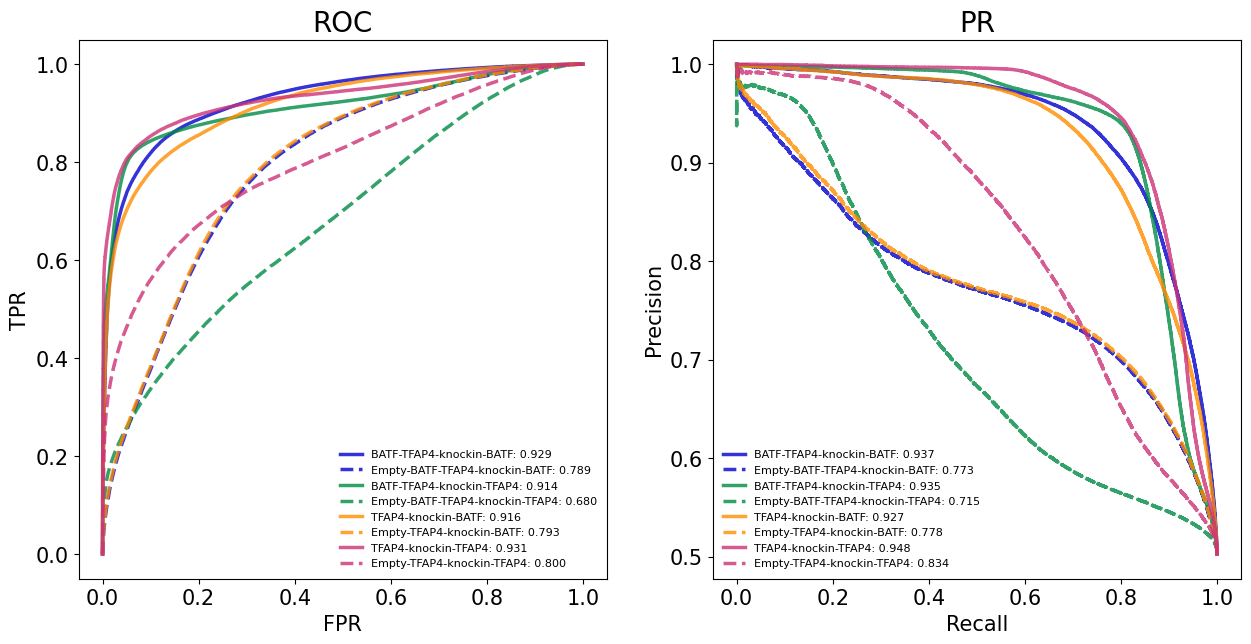

In [32]:
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(15, 7), ncols=2, gridspec_kw={'width_ratios': [1, 1]})

#colors = _get_colors(4)
#colors = ['#0000CD', '#008B45', '#FF8C00', '#CD3278', '#FFD700', '#8968CD']
colors = ['#0000CD', '#008B45', '#FF8C00', '#CD3278']

all_auc = {}
all_aupr = {}
#for color, group in zip(colors, ['BATF-TFAP4-knockin-BATF', 'BATF-TFAP4-knockin-TFAP4', 'TFAP4-knockin-BATF', 'TFAP4-knockin-TFAP4', 'tNGFR-knockin-BATF', 'tNGFR-knockin-TFAP4']):
for color, group in zip(colors, ['BATF-TFAP4-knockin-BATF', 'BATF-TFAP4-knockin-TFAP4', 'TFAP4-knockin-BATF', 'TFAP4-knockin-TFAP4']):
    group_data = eval_result[eval_result['group'] == group]
    fpr, tpr, _ = roc_curve(group_data['target'], group_data['predict'])
    roc_auc = auc(fpr, tpr)
    all_auc[group] = roc_auc    

    precision, recall, thresholds = precision_recall_curve(group_data['target'], group_data['predict'])
    pr_auc = auc(recall, precision)
    all_aupr[group] = pr_auc

    ax[0].plot(fpr, tpr, color=color, lw=2.5, alpha=0.8, label=f'{group}: {roc_auc:0.3f}')

    ax[1].plot(recall, precision, color=color, lw=2.5, alpha=0.8, label=f'{group}: {pr_auc:0.3f}')

    # ---------------------- empty ---------------------- #
    group = ''.join(["Empty-",group])
    group_data = eval_result[eval_result['group'] == group]
    fpr, tpr, _ = roc_curve(group_data['target'], group_data['predict'])
    roc_auc = auc(fpr, tpr)
    all_auc[group] = roc_auc    

    precision, recall, thresholds = precision_recall_curve(group_data['target'], group_data['predict'])
    pr_auc = auc(recall, precision)
    all_aupr[group] = pr_auc

    ax[0].plot(fpr, tpr, color=color, lw=2.5, alpha=0.8, linestyle='--', label=f'{group}: {roc_auc:0.3f}')
    ax[1].plot(recall, precision, color=color, lw=2.5, alpha=0.8, linestyle='--', label=f'{group}: {pr_auc:0.3f}')     

ax[0].set_xlabel("FPR", fontsize=15)
ax[0].set_ylabel("TPR", fontsize=15)
ax[0].set_title("ROC", fontsize=20)

ax[1].set_xlabel("Recall", fontsize=15)
ax[1].set_ylabel("Precision", fontsize=15)
ax[1].set_title("PR", fontsize=20)


ax[0].legend(loc="lower right", frameon=False, fontsize=8)
ax[1].legend(loc="lower left", frameon=False, fontsize=8)

all_df = pd.DataFrame({
    "Group" : all_auc.keys(),
    "AUC": all_auc.values(),
    "AUPR": all_aupr.values()
})

fig.savefig("../results/eval.compare.empty.2.pdf" ,bbox_inches="tight")

In [33]:
eval_result

,chr,start,end,target,predict,predict_aftercutoff,group
0,chr21,21484830,21485854,0,0.002459,0,BATF-TFAP4-knockin-BATF
1,chr1,1385975,1386999,0,0.036944,0,BATF-TFAP4-knockin-BATF
2,chr8,23204822,23205846,0,0.124834,0,BATF-TFAP4-knockin-BATF
3,chr1,197418363,197419387,0,0.011235,0,BATF-TFAP4-knockin-BATF
4,chr1,11584561,11585585,0,0.001812,0,BATF-TFAP4-knockin-BATF
...,...,...,...,...,...,...,...
201010,chr11,134252988,134254012,1,0.532576,0,Empty-tNGFR-knockin-TFAP4
201011,chr11,134253188,134254212,1,0.724138,0,Empty-tNGFR-knockin-TFAP4
201012,chr11,134331188,134332212,1,0.515004,0,Empty-tNGFR-knockin-TFAP4
201013,chr11,134331388,134332412,1,0.619490,0,Empty-tNGFR-knockin-TFAP4


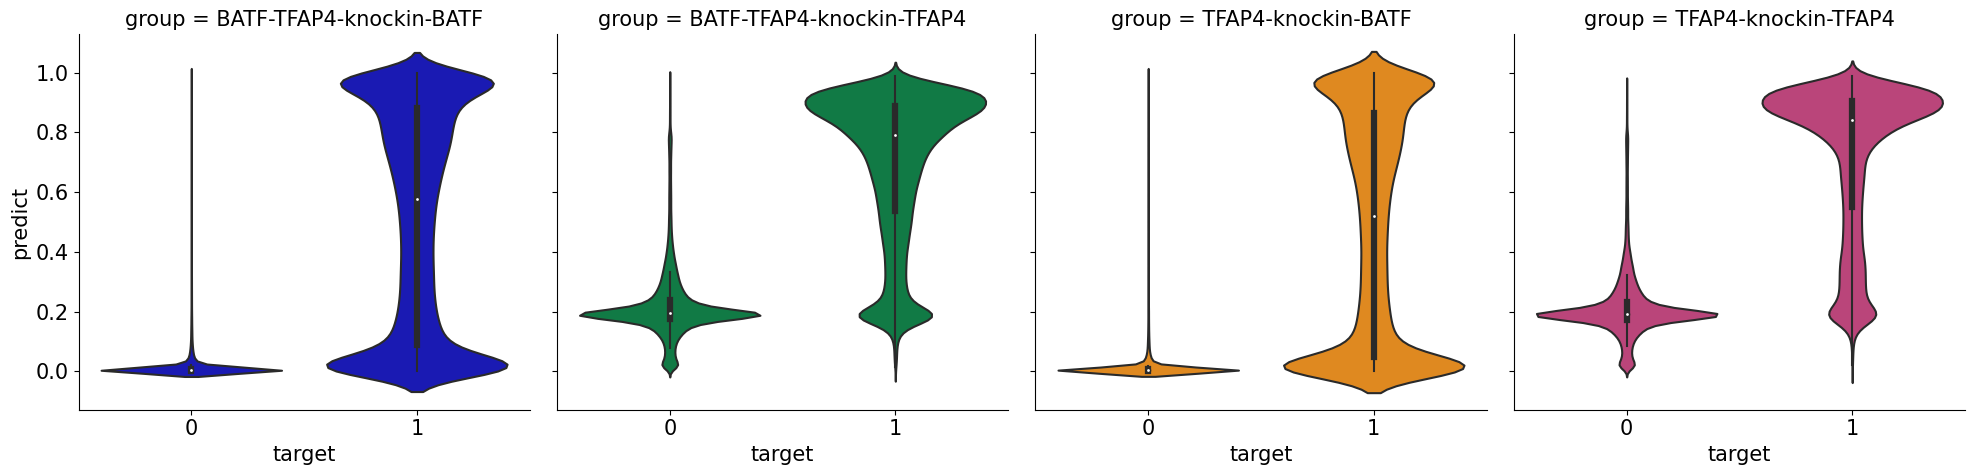

In [46]:
select_groups = ['BATF-TFAP4-knockin-BATF', 'BATF-TFAP4-knockin-TFAP4', 'TFAP4-knockin-BATF', 'TFAP4-knockin-TFAP4']
select_eval_result = eval_result[eval_result['group'].isin(select_groups)]

ax = sns.catplot(data=select_eval_result.sort_values('group'),kind="violin", hue="group", col="group", x="target", y="predict", dodge=False, palette=colors)

#ax.set(xlim=(-0.05, 1.05), ylim=(-.05, 1.05))
#ax.set(ylim=(0, None))
#fig.savefig("../results/eval.violin.knockin.pdf" ,bbox_inches="tight")

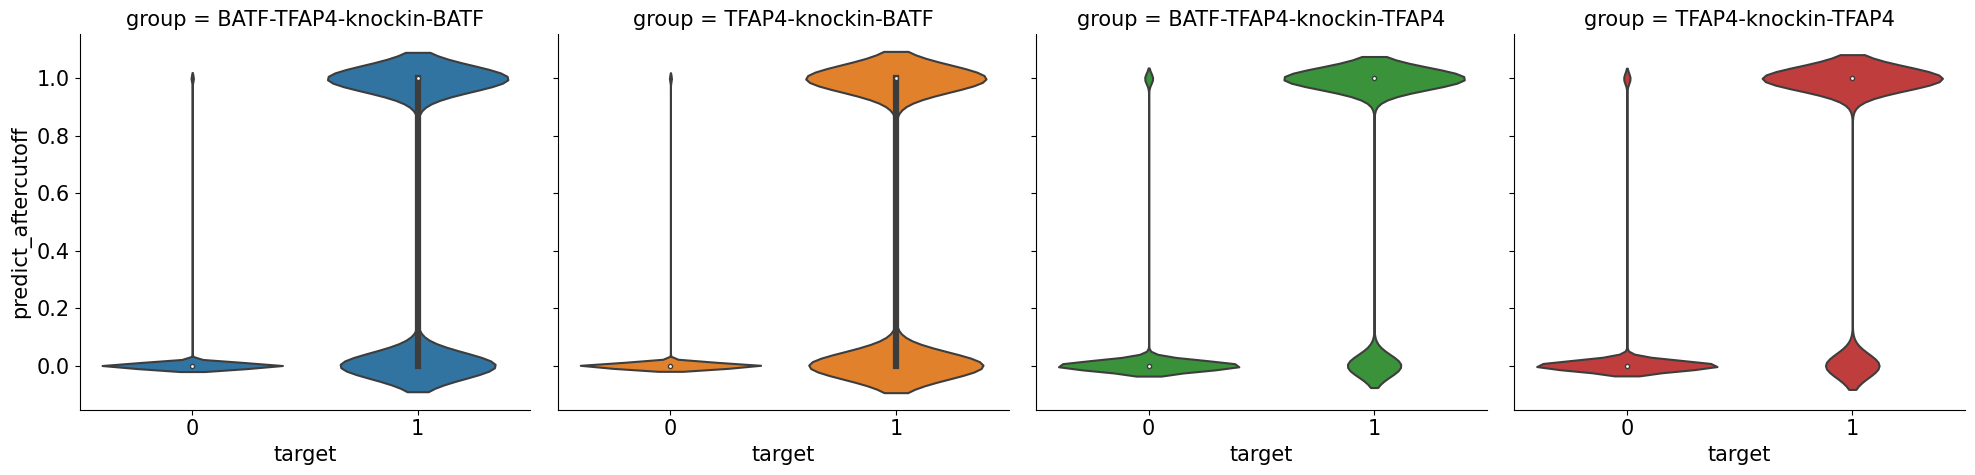

In [44]:
cutoff = 0.5
eval_result["predict_aftercutoff"] = [ 1 if i > cutoff else 0 for i in eval_result['predict'] ]
select_groups = ['BATF-TFAP4-knockin-BATF', 'BATF-TFAP4-knockin-TFAP4', 'TFAP4-knockin-BATF', 'TFAP4-knockin-TFAP4']
select_eval_result = eval_result[eval_result['group'].isin(select_groups)]

ax = sns.catplot(data=select_eval_result,kind="violin", hue="group", col="group", x="target", y="predict_aftercutoff", dodge=False)
#ax.set(xlim=(-0.05, 1.05), ylim=(-.05, 1.05))
#ax.set(ylim=(0, None))
#fig.savefig("../results/eval.violin.knockin.pdf" ,bbox_inches="tight")